In [2]:
import glob
import pandas as pd
import librosa as lbr
from scipy.signal import hilbert
import mne
import mne_bids
import numpy as np
import matplotlib.pyplot as plt

In [3]:
waves = sorted(glob.glob("../data/MASC-MEG/stimuli/audio/lw1_*.wav"))
waves

['../data/MASC-MEG/stimuli/audio/lw1_0.wav',
 '../data/MASC-MEG/stimuli/audio/lw1_1.wav',
 '../data/MASC-MEG/stimuli/audio/lw1_2.wav',
 '../data/MASC-MEG/stimuli/audio/lw1_3.wav']

In [4]:
X = []
for f in waves:
    x, sr = lbr.load('../data/MASC-MEG/stimuli/audio/lw1_0.wav', sr=None)
    X.append(x)
X = np.concatenate(X)

In [5]:
S = lbr.feature.melspectrogram(y=X, sr=sr, n_fft=2048, hop_length=128, n_mels=208, window="hamming")

In [144]:
pitches, mags = lbr.piptrack(S=S)

In [145]:
mags.shape

(208, 66069)

In [146]:
plt.plot(mags.T[:1000])
plt.show()

In [6]:
bids_path = mne_bids.BIDSPath(
    subject="12",
    session="0",
    task="0",
    datatype="meg",
    root="../data/MASC-MEG/",
)

In [7]:
raw = mne_bids.read_raw_bids(bids_path)

Extracting SQD Parameters from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_events.tsv.
Reading channel info from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.


/tmp/ipykernel_93002/3316973082.py:1: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


In [8]:
raw = raw.pick_types(meg=True, misc=False, eeg=False, eog=False, ecg=False)

raw.load_data().filter(
    0.5, 30.0, n_jobs=1, verbose=False
)

Reading 0 ... 371999  =      0.000 ...   371.999 secs...


<RawKIT | sub-12_ses-0_task-0_meg.con, 208 x 372000 (372.0 s), ~590.5 MB, data loaded>

In [9]:
raw_down = raw.copy().resample(sfreq=250)

In [10]:
y = raw_down.get_data()

In [11]:
y.shape

(208, 93000)

In [13]:
from scipy.stats import zscore

y = zscore(y, axis=1)

In [178]:
plt.plot(y.T[:1000])
plt.show()

In [14]:
from scipy.signal import hilbert

xa = hilbert(X)

In [15]:
from scipy.signal import butter, sosfiltfilt

sos = butter(3, 50, btype='low', analog=False, fs=sr, output="sos")
xaf = sosfiltfilt(sos, np.abs(xa))

In [16]:
plt.plot(X[:100000])
plt.plot(np.abs(xaf[:100000]))

In [21]:
pitches, mags = lbr.piptrack(y=X, sr=sr, n_fft=2048, hop_length=128, window="hamming")

In [44]:
indexes = mags.argmax(axis=0)

In [122]:
f0s = np.array([pitches[indexes[t], t] for t in range(pitches.shape[1])])

In [128]:
sos = butter(3, 25, btype='low', analog=False, fs=sr/128, output="sos")
f0sf = sosfiltfilt(sos, f0s)

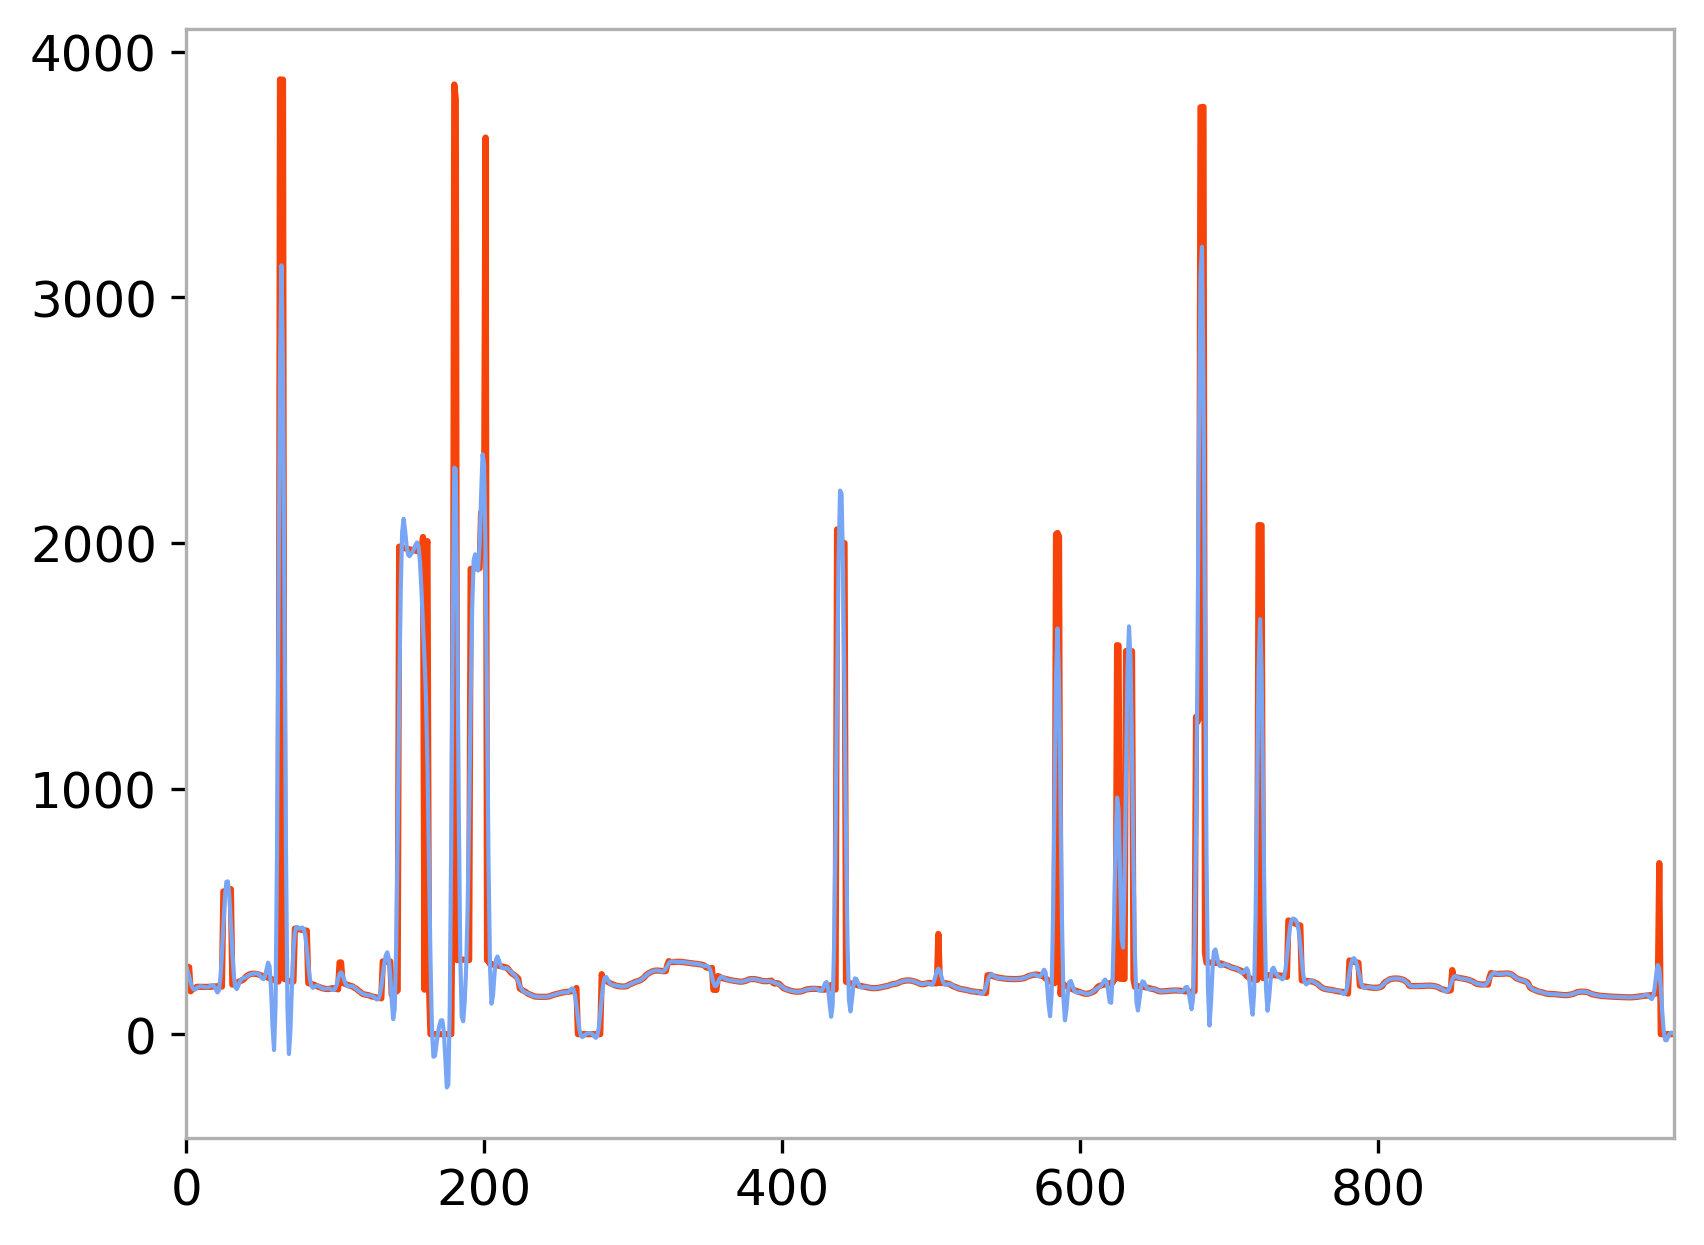

In [129]:
plt.plot(f0s[:1000])
plt.plot(f0sf[:1000], lw=1)

In [130]:
f0s_r = np.clip(lbr.resample(f0sf, orig_sr=sr/128, target_sr=250), 0, None)

In [131]:
xa_r = lbr.resample(xaf, orig_sr=sr, target_sr=250)

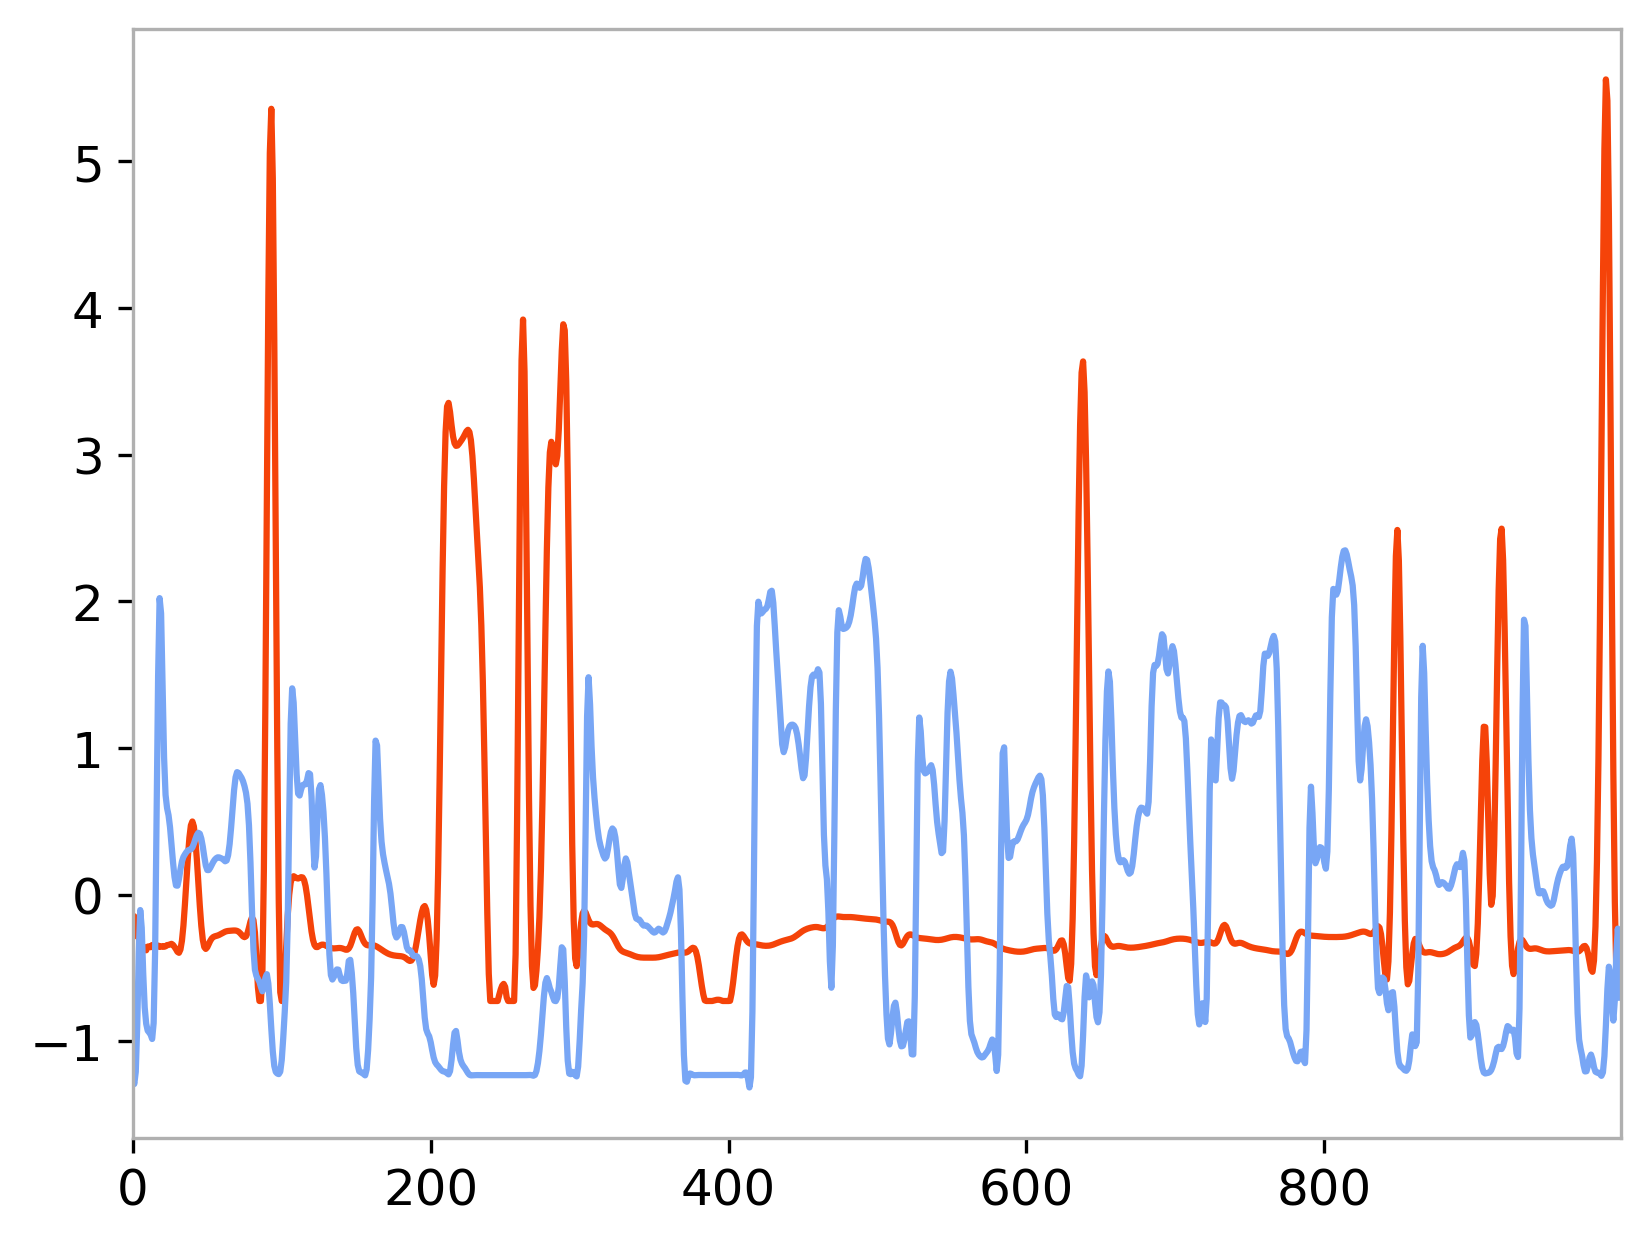

In [132]:
plt.plot(zscore(f0s_r[:1000]))
plt.plot(zscore(xa_r[:1000]))

In [143]:
xa_r.shape, f0s_r.shape

((95882,), (95883,))

In [146]:
min_shape = y.shape[1]
xa_r = xa_r[:min_shape]
f0s_r = f0s_r[:min_shape]

In [149]:
acc = np.c_[xa_r, f0s_r]

In [238]:
acc = xa_r.reshape(-1, 1)

In [239]:
acc.shape

(93000, 1)

In [278]:
acc = zscore(acc, axis=0)

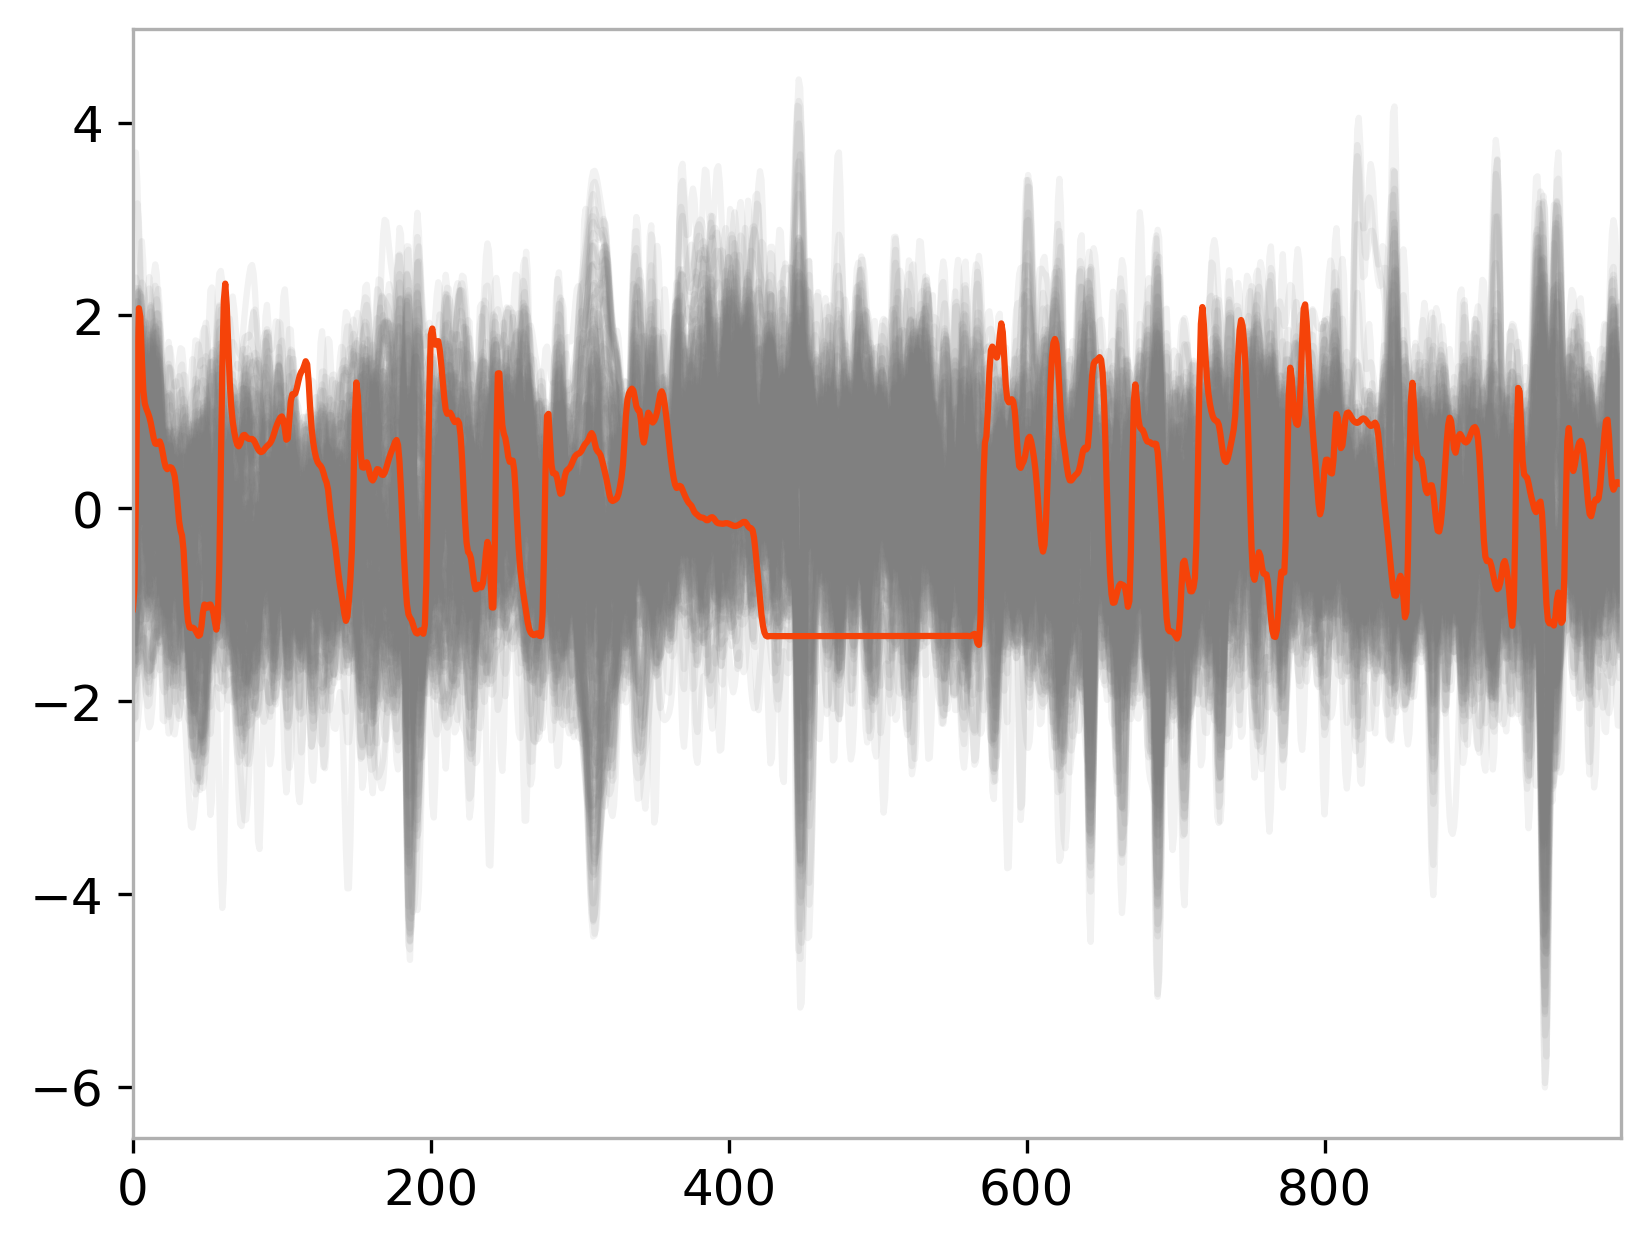

In [284]:
plt.plot(y.T[1000:2000], color="gray", alpha=0.1)
plt.plot(acc[1000:2000])
plt.show()

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 1 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 2 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

split 3 / 3
Fitting 1 epochs, 1 channels


  0%|          | Sample : 0/2 [00:00<?,       ?it/s]

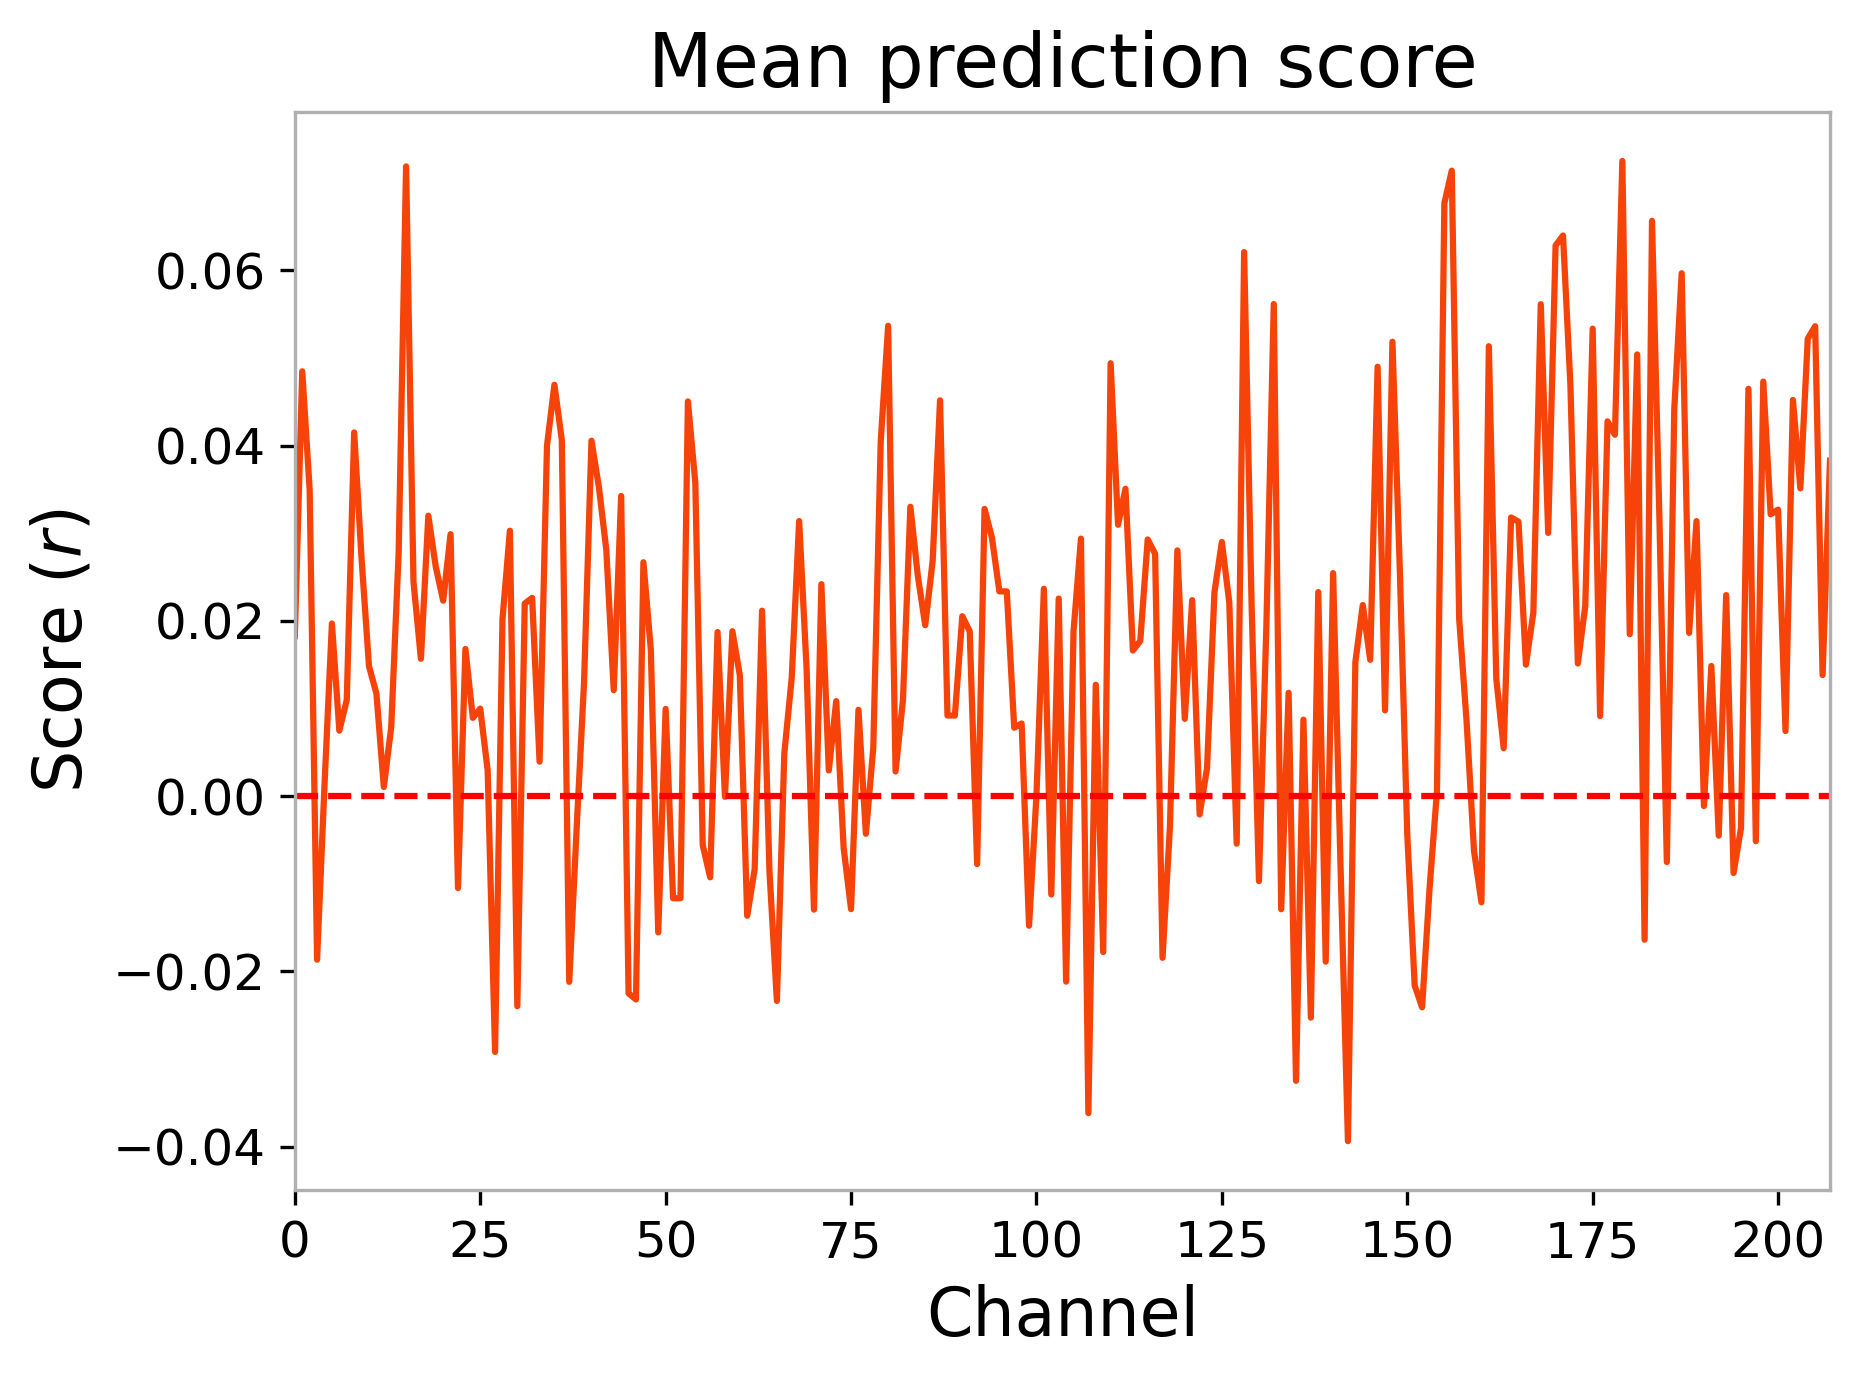

In [280]:
from sklearn.model_selection import KFold

tmax = 0.4
tmin = 0.0


all_scores = []
all_coefs = []
for ridge in 10.0**(np.arange(-6, 7)):
    rf = mne.decoding.ReceptiveField(
        tmin=tmin, 
        tmax=tmax, 
        sfreq=250,
        estimator=ridge, 
        scoring="corrcoef",
        edge_correction=True
    )

    # We'll have (tmax - tmin) * sfreq delays
    # and an extra 2 delays since we are inclusive on the beginning / end index
    n_delays = int((tmax - tmin) * 250) + 1

    n_splits = 3
    cv = KFold(n_splits=n_splits)

    # Iterate through splits, fit the model, and predict/test on held-out data
    coefs = np.zeros((n_splits, 208, acc.shape[1], n_delays))
    scores = np.zeros((n_splits, 208))
    for ii, (train, test) in enumerate(cv.split(acc)):
        print('split %s / %s' % (ii + 1, n_splits))
        rf.fit(acc[train], y.T[train])
        scores[ii] = rf.score(acc[test], y.T[test])
        # coef_ is shape (n_outputs, n_features, n_delays)
        coefs[ii] = rf.coef_

    times = rf.delays_ / float(rf.sfreq)

    # Average scores and coefficients across CV splits
    mean_coefs = coefs.mean(axis=0)
    mean_scores = scores.mean(axis=0)
    
    all_coefs.append(mean_coefs)
    all_scores.append(mean_scores)

# Plot mean prediction scores across all channels
fig, ax = plt.subplots()
ix_chs = np.arange(208)
ax.plot(ix_chs, mean_scores)
ax.axhline(0, ls='--', color='r')
ax.set(title="Mean prediction score", xlabel="Channel", ylabel="Score ($r$)")
mne.viz.tight_layout()

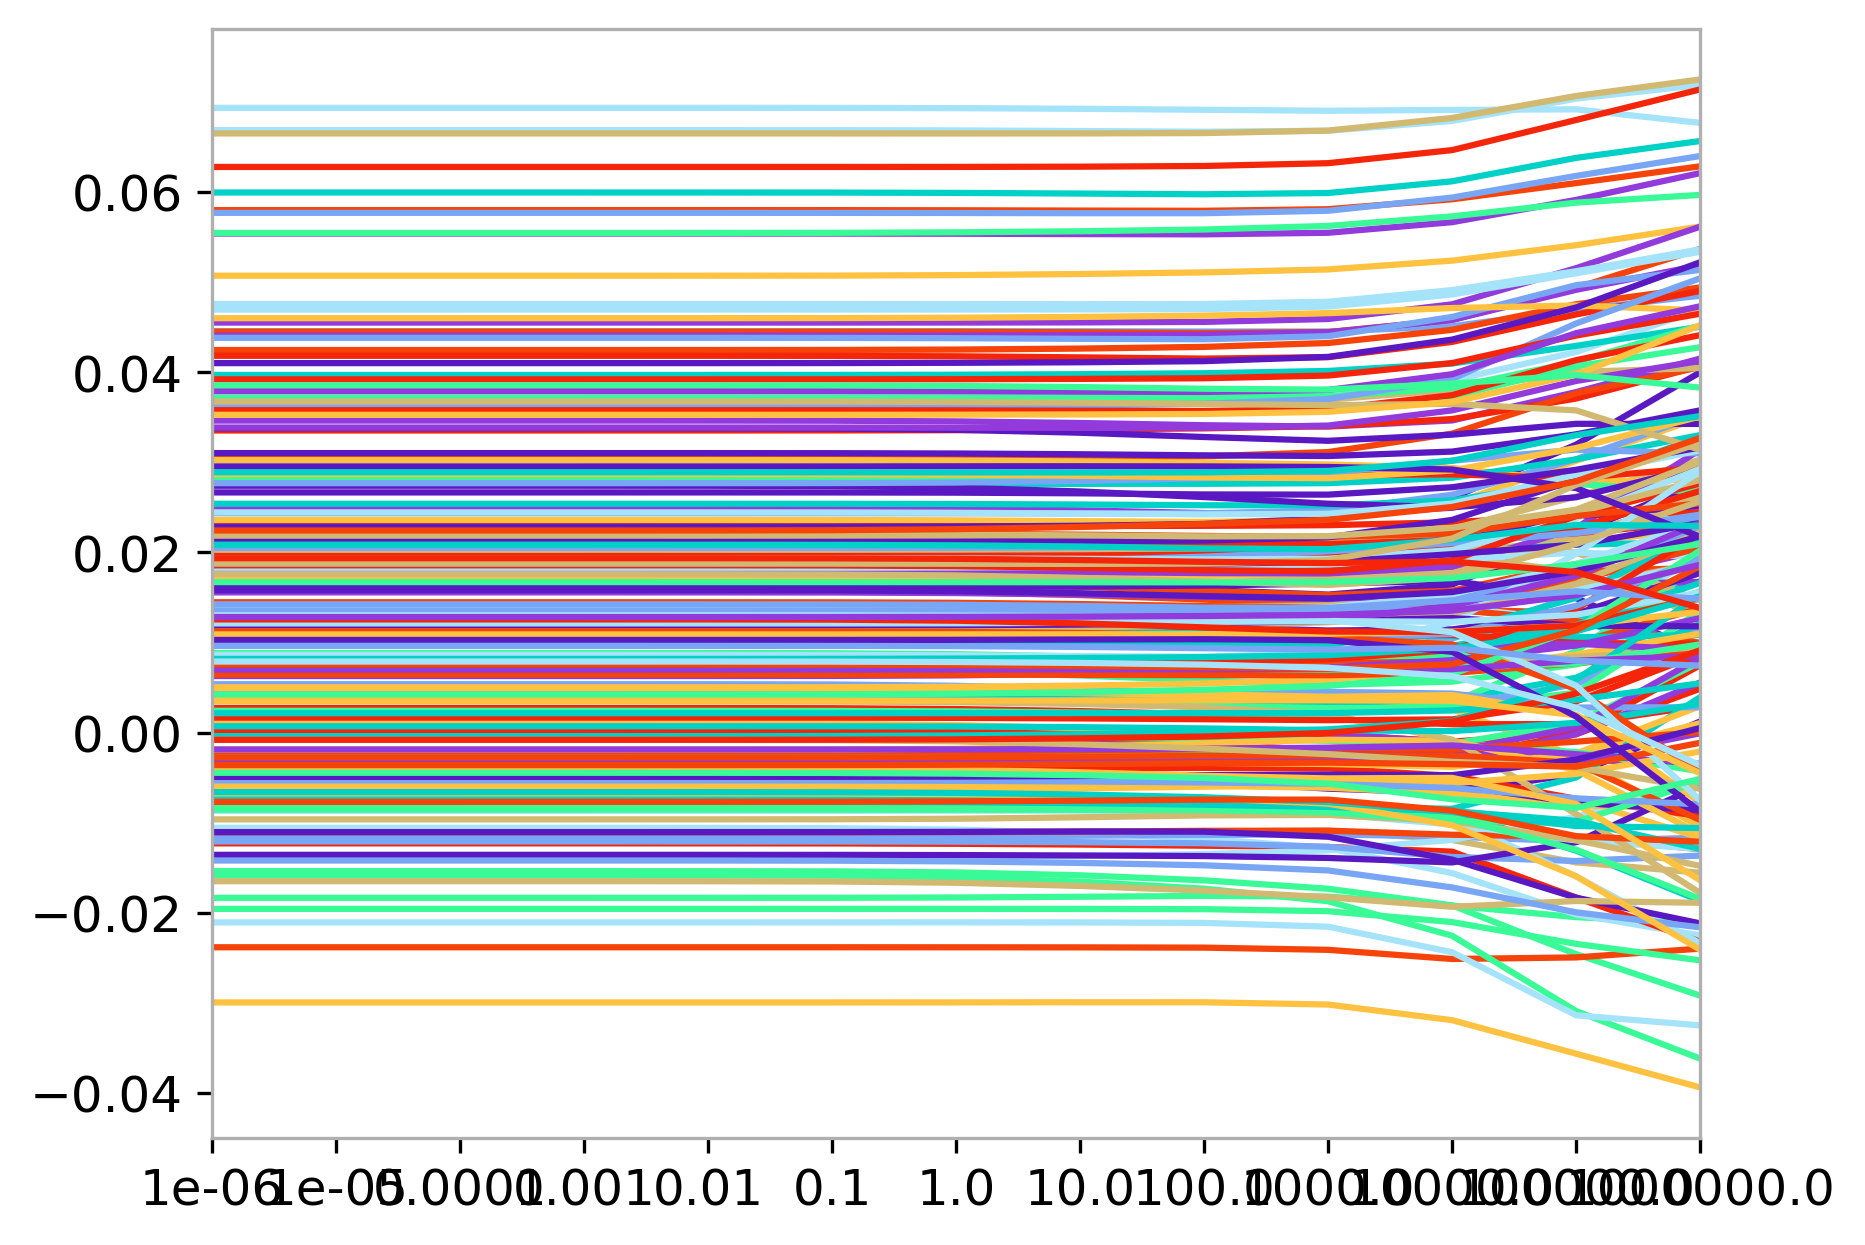

In [281]:
r = np.arange(-6, 7)
plt.plot(r, all_scores)
plt.xticks(r, 10.0**np.arange(-6, 7))
plt.show()

In [282]:
coefs.mean(axis=0).shape

(208, 1, 101)

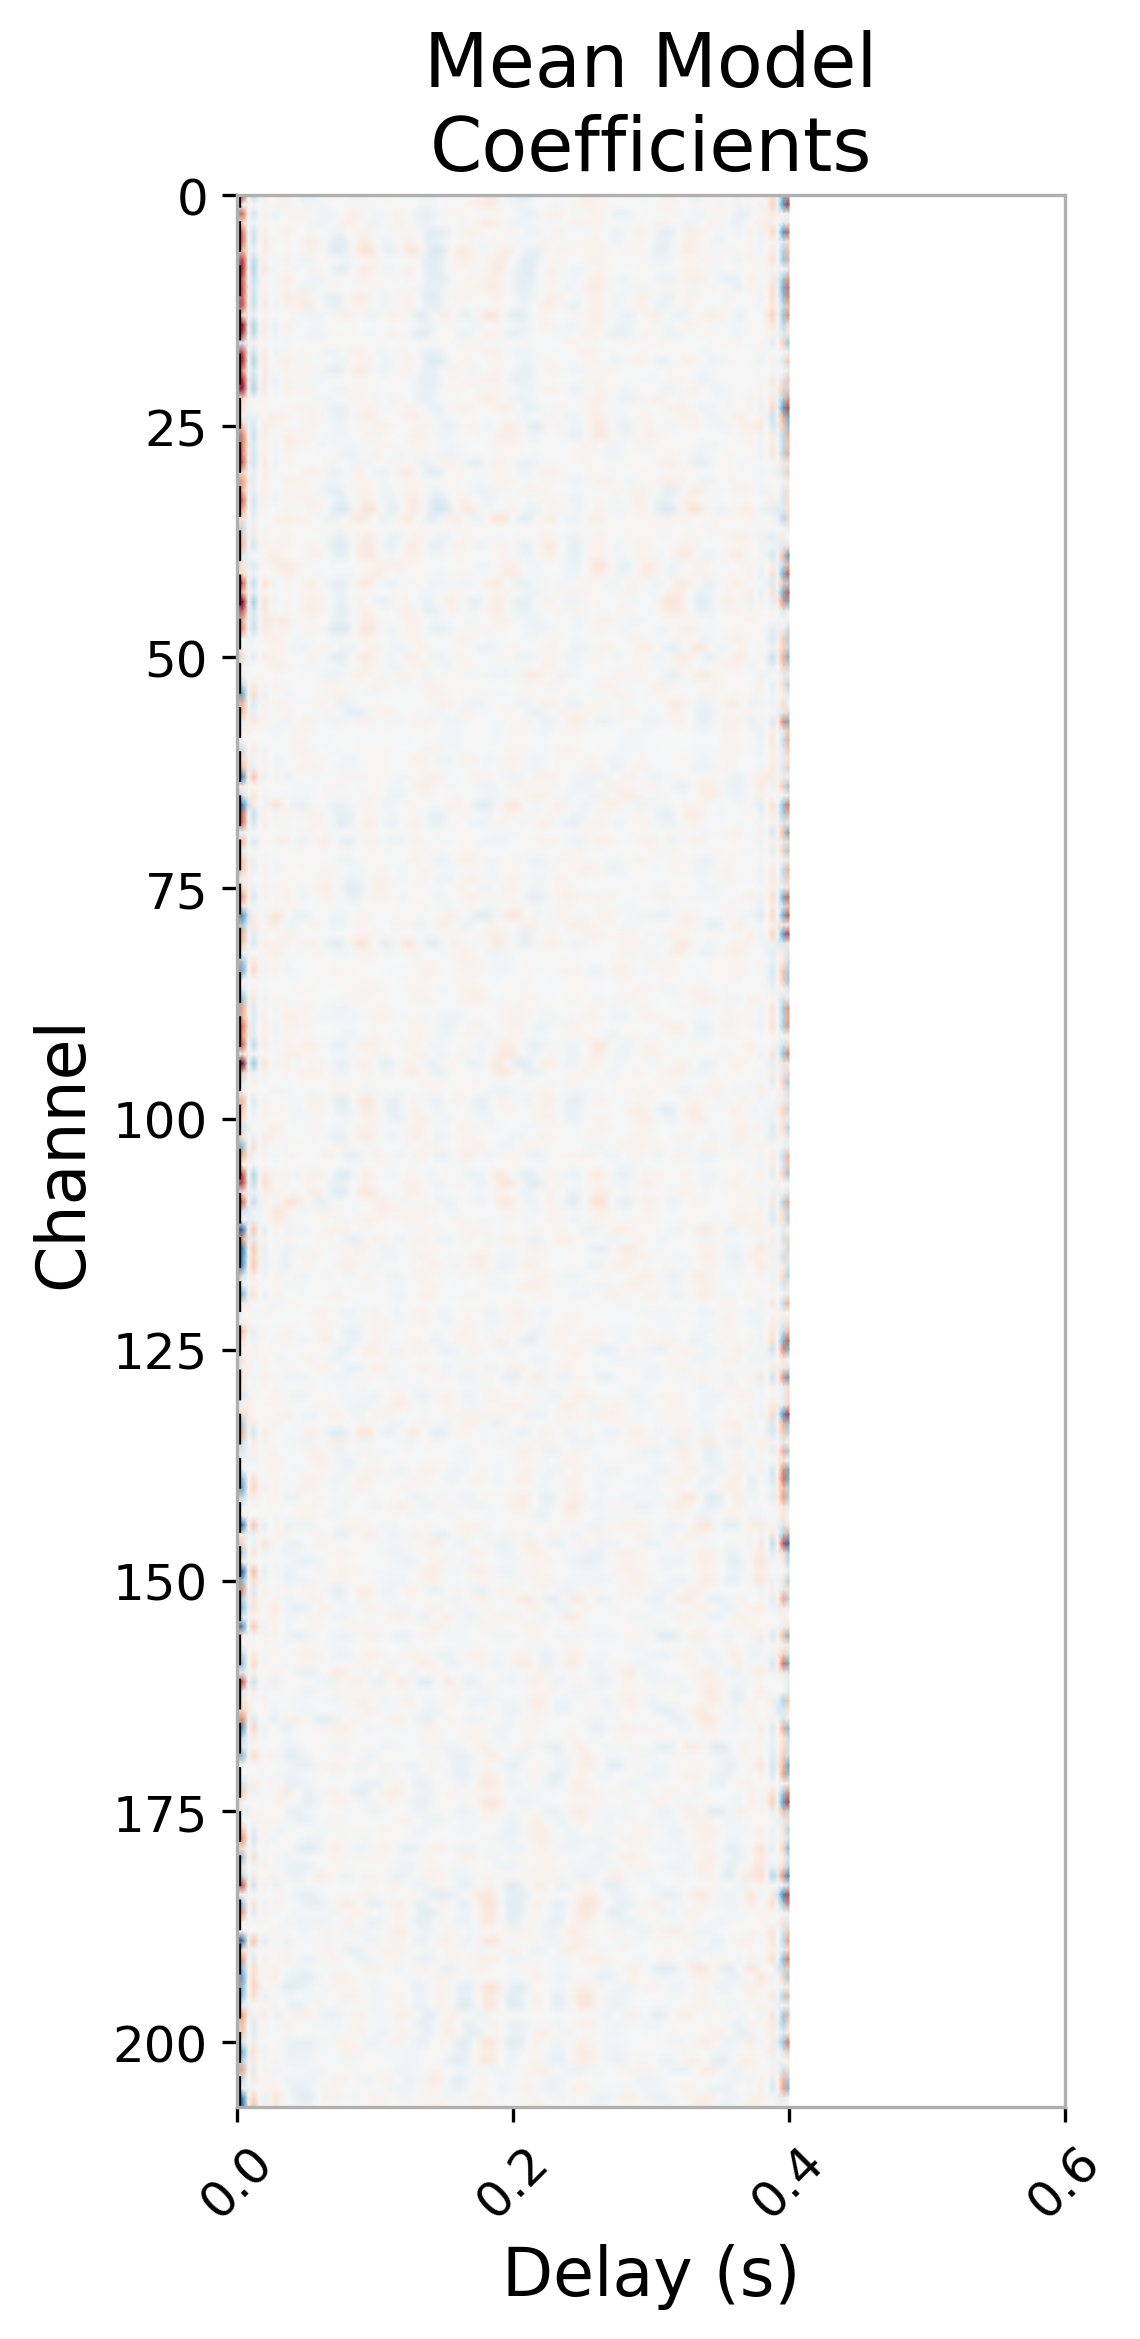

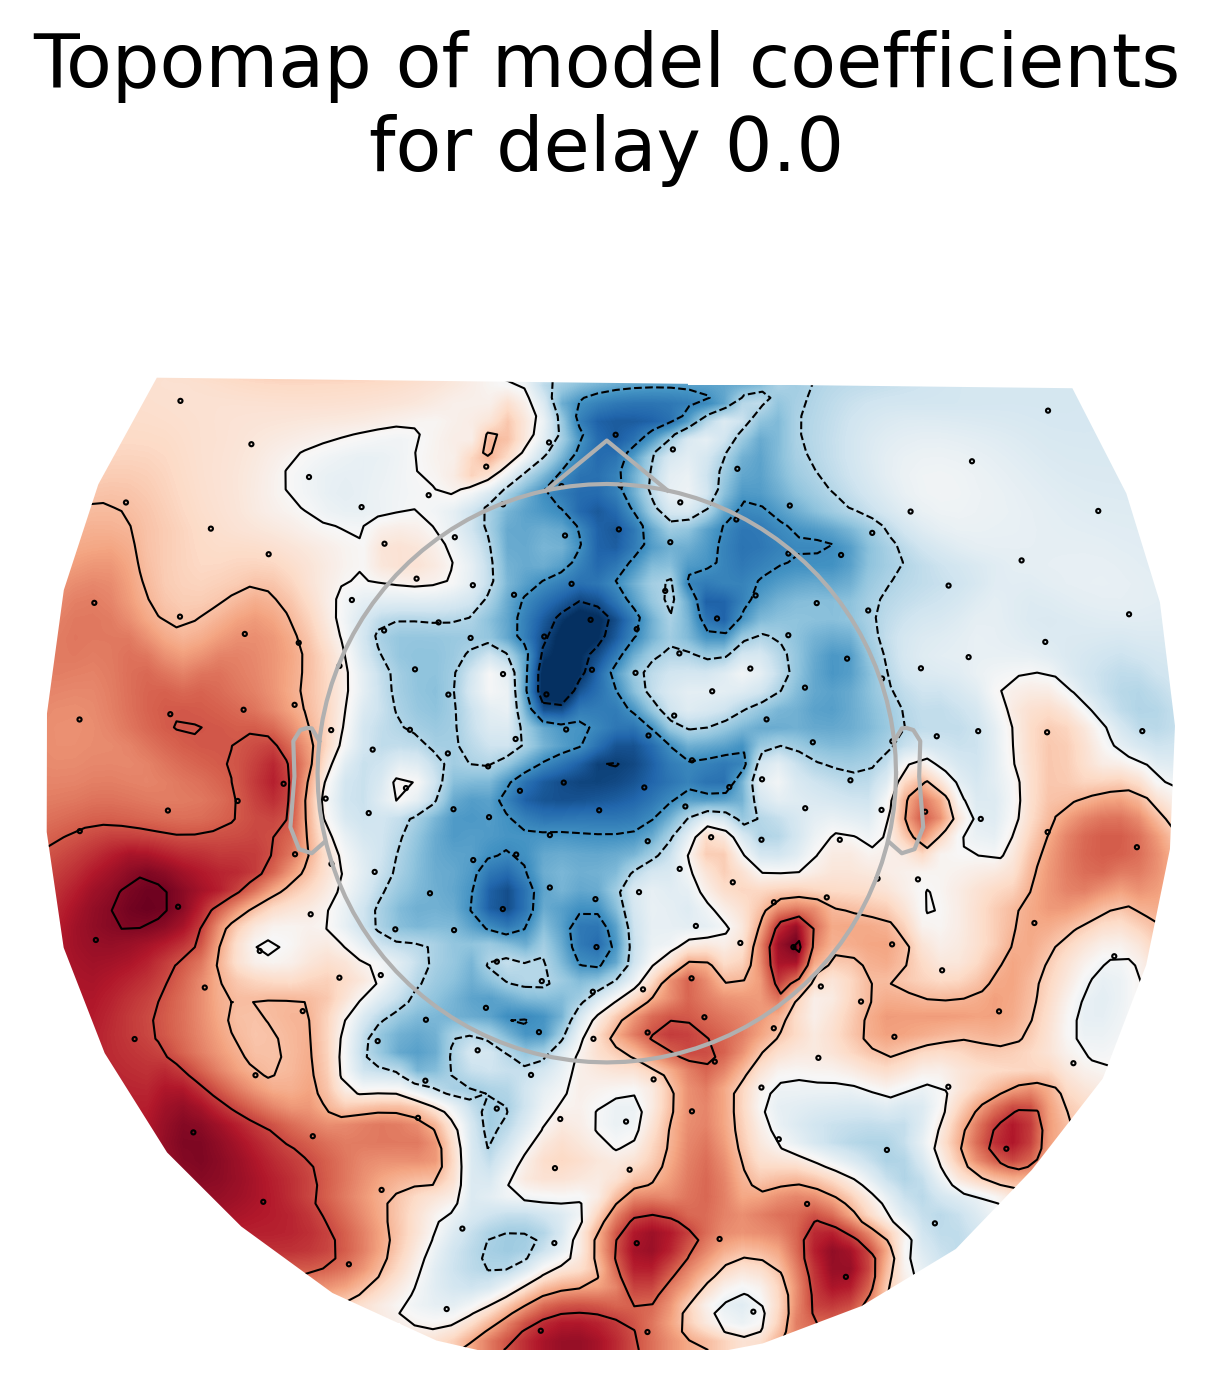

In [283]:
mean_coefs = all_coefs[8]

# Print mean coefficients across all time delays / channels (see Fig 1)
time_plot = 0.0  # For highlighting a specific time.
fig, ax = plt.subplots(figsize=(4, 8))
max_coef = mean_coefs.max()
ax.pcolormesh(times, ix_chs, mean_coefs.squeeze(), cmap='RdBu_r',
              vmin=-max_coef, vmax=max_coef, shading='gouraud')
ax.axvline(time_plot, ls='--', color='k', lw=2)
ax.set(xlabel='Delay (s)', ylabel='Channel', title="Mean Model\nCoefficients",
       xlim=times[[0, -1]], ylim=[len(ix_chs) - 1, 0],
       xticks=np.arange(tmin, tmax + .2, .2))
plt.setp(ax.get_xticklabels(), rotation=45)
mne.viz.tight_layout()

# Make a topographic map of coefficients for a given delay (see Fig 2C)
ix_plot = np.argmin(np.abs(time_plot - times))
fig, ax = plt.subplots()
mne.viz.plot_topomap(mean_coefs.squeeze()[:, ix_plot], pos=raw.info, axes=ax, show=False,
                     vlim=(-max_coef, max_coef))
ax.set(title="Topomap of model coefficients\nfor delay %s" % time_plot)
mne.viz.tight_layout()

In [194]:
preds = model.predict(acc)

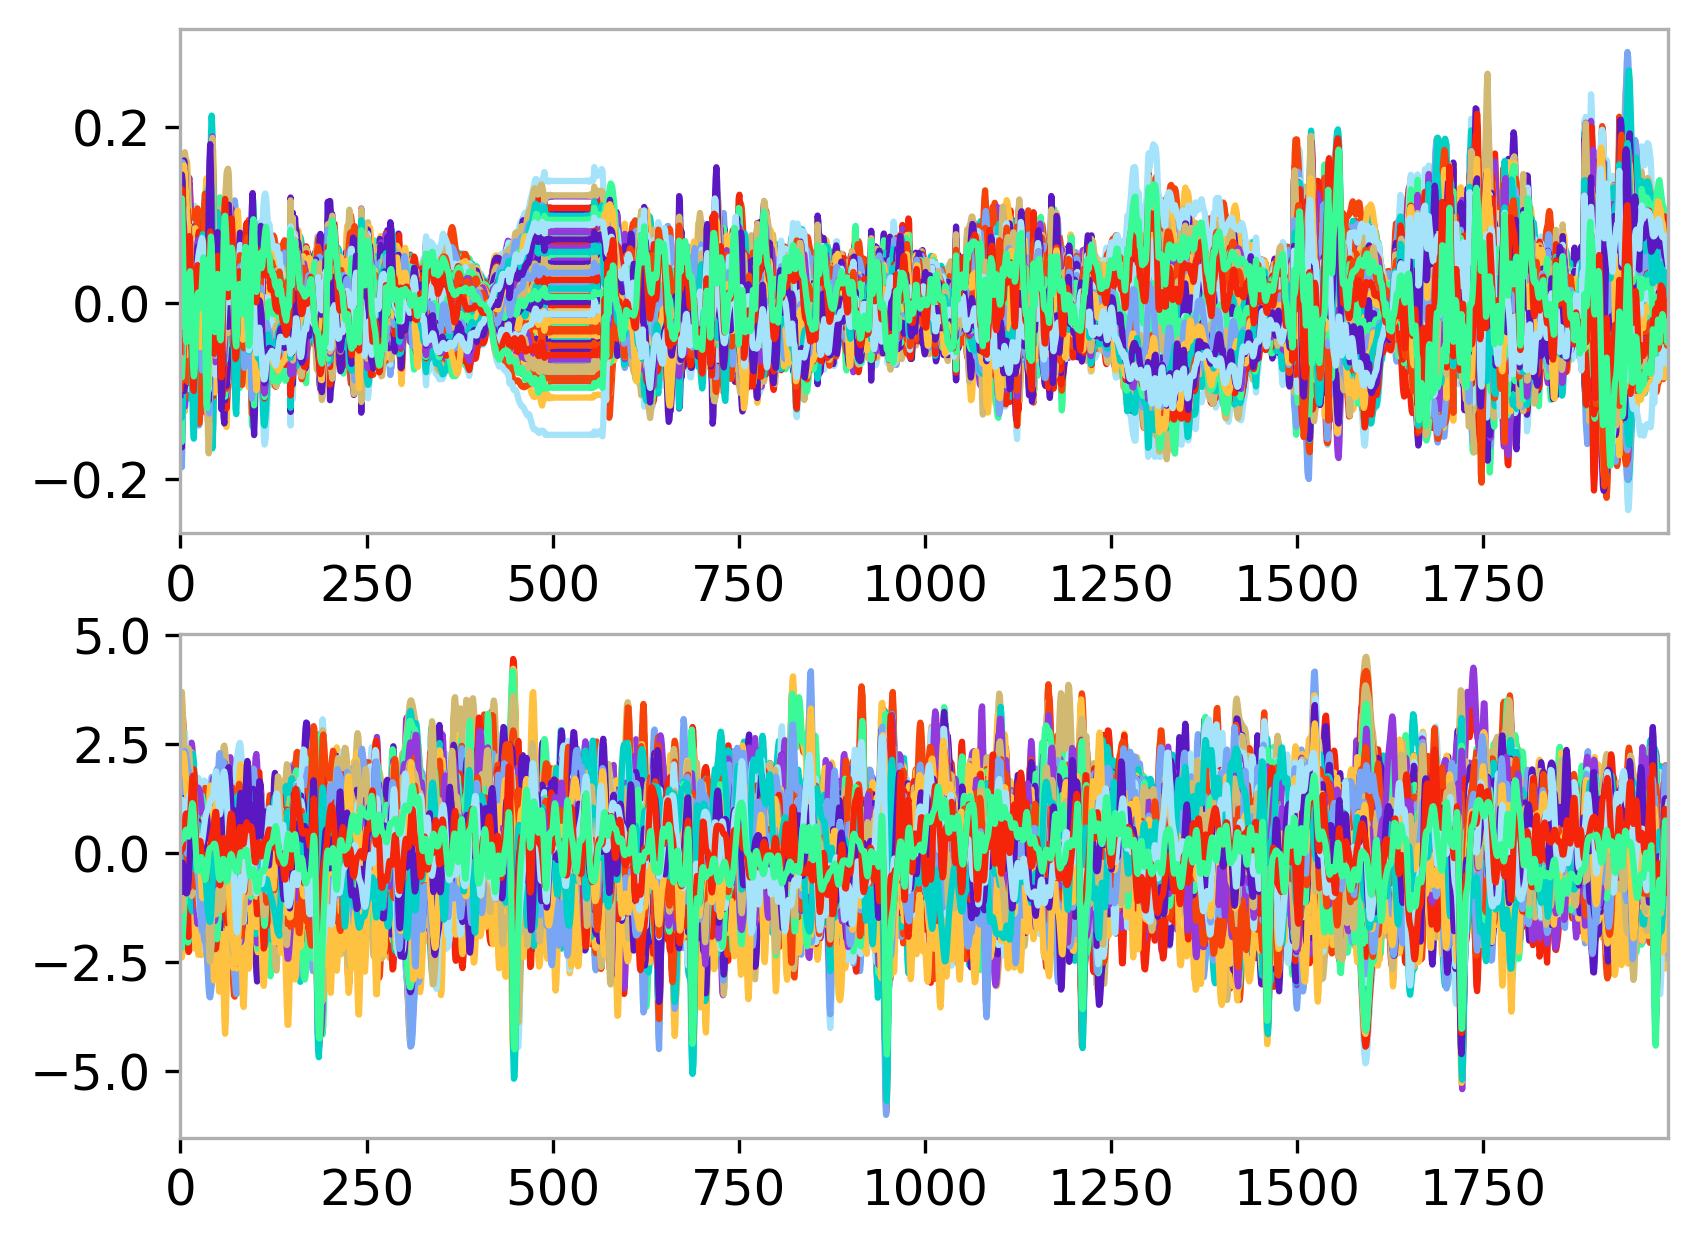

In [199]:
plt.subplot(211)
plt.plot(preds[1000:3000])
plt.subplot(212)
plt.plot(y.T[1000:3000])
plt.show()

In [196]:
env_c = model.coef_[:, 0, :]
pitch_c = model.coef_[:, 1, :]

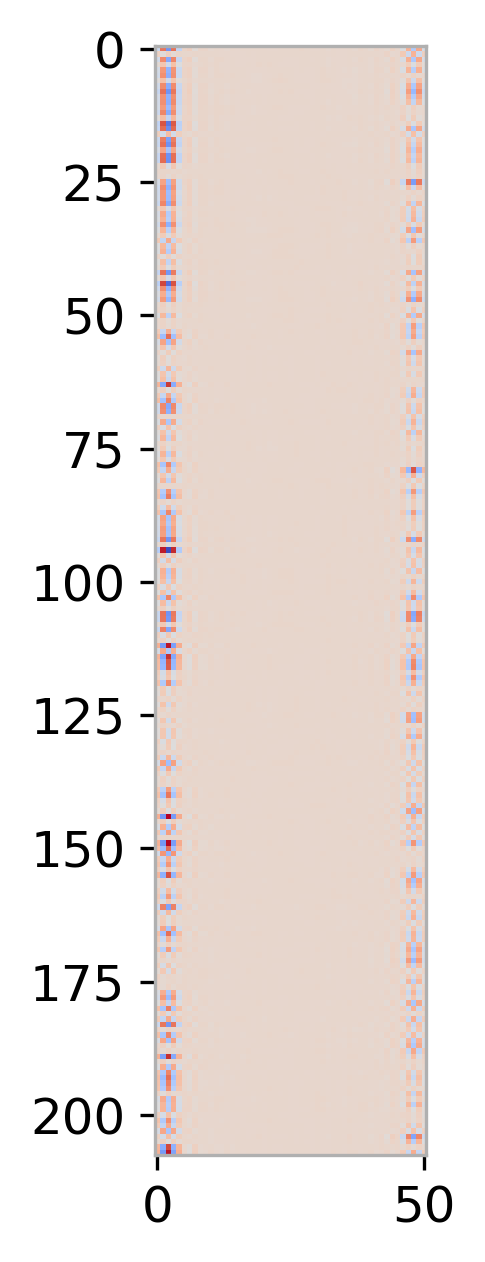

In [197]:
plt.imshow(env_c, cmap="coolwarm")

In [88]:
from scipy.stats import zscore
X = zscore(X)
pitches, mags = lbr.piptrack(y=X, sr=sr, n_fft=2048, hop_length=128, window="hamming")
acc = np.r_[mags, pitches]
acc.shape

(2050, 66069)

In [89]:
acc = lbr.resample(acc, orig_sr=sr/128, target_sr=250)
acc.shape

(2050, 95883)

In [90]:
acc.shape

(2050, 95883)

In [91]:
acoustic = acc[:, :y.shape[1]]

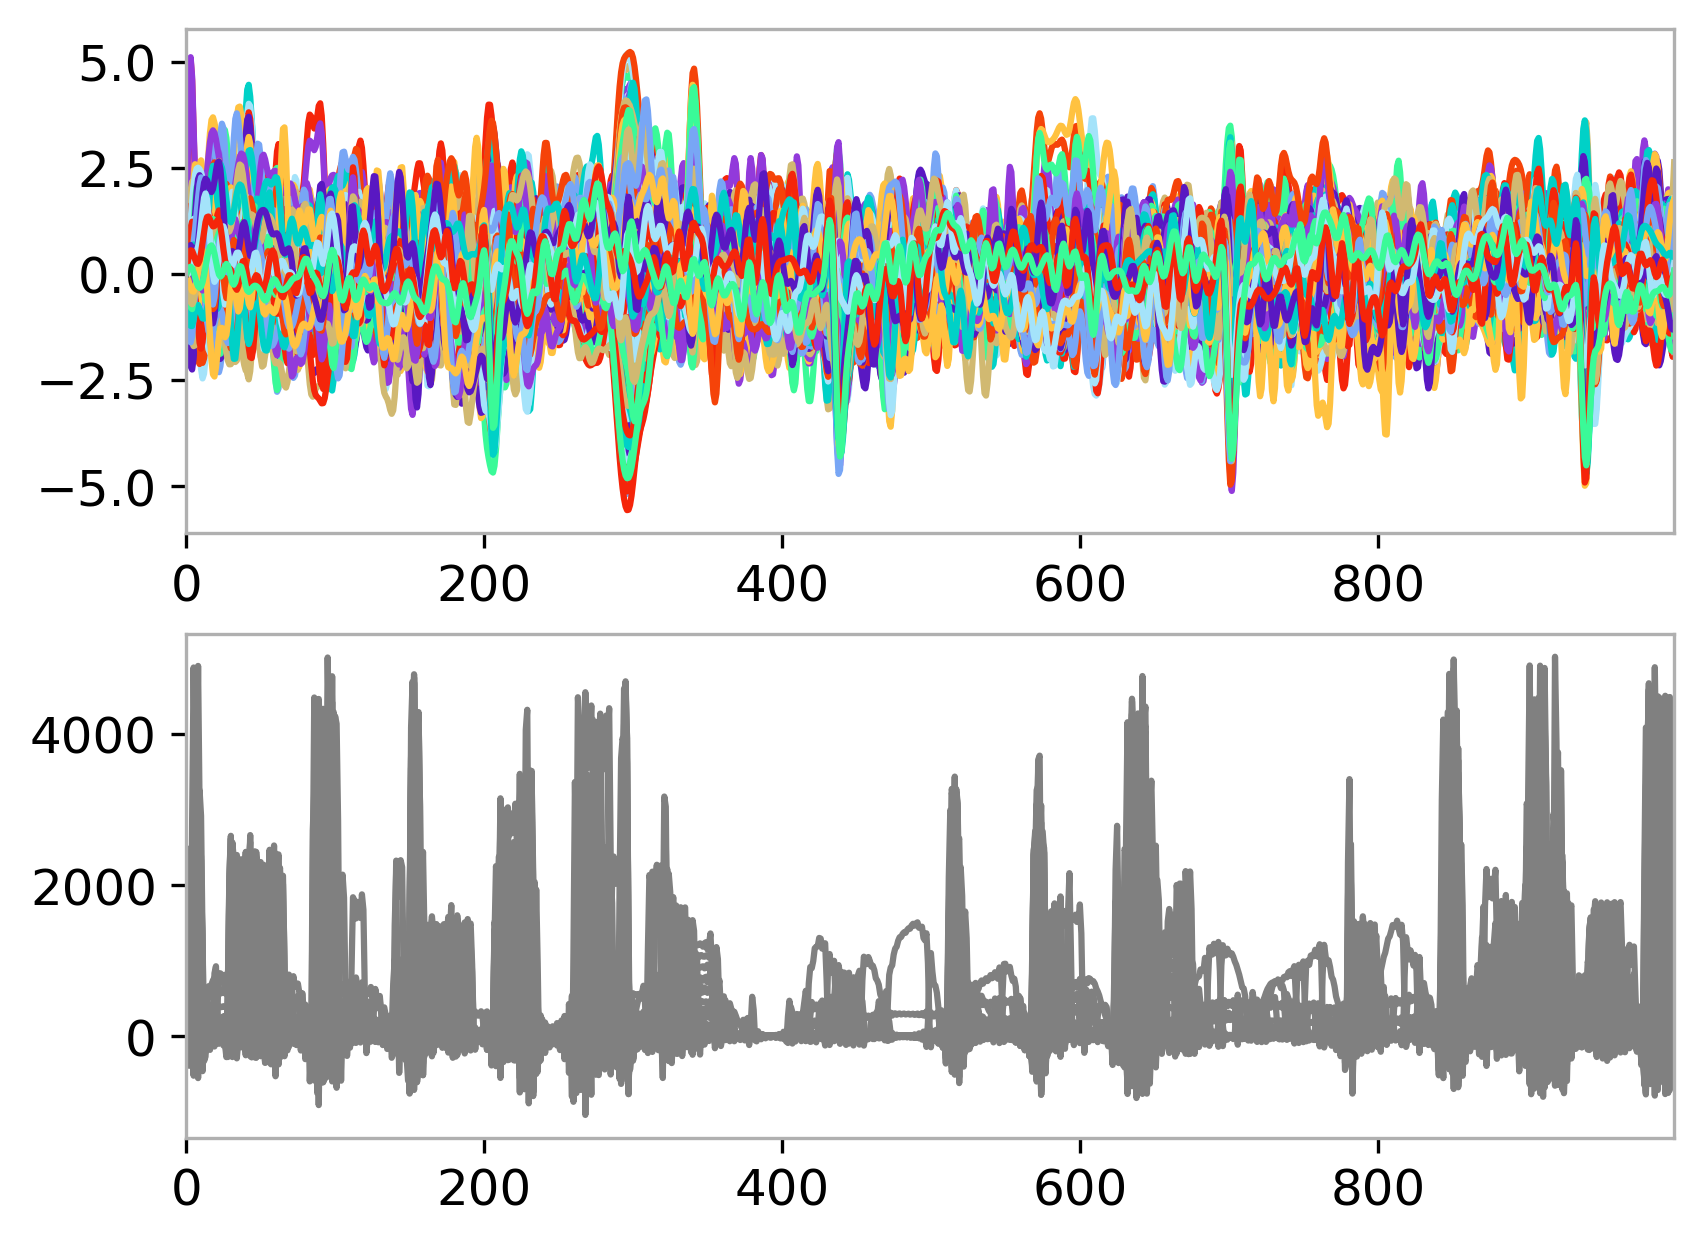

In [93]:
plt.subplot(211)
plt.plot(y.T[:1000])
plt.subplot(212)
plt.plot(acoustic.T[:1000], color="gray")
plt.show()

In [94]:
acoustic = acoustic.T
y = y.T

In [95]:
acoustic.shape, y.shape

((93000, 2050), (93000, 208))

In [96]:
model = mne.decoding.ReceptiveField(tmin=-0.2, tmax=0.0, sfreq=250, estimator=1.0)

In [101]:
250 * 0.001

0.25

In [102]:
model.fit(acoustic, y)

MemoryError: Unable to allocate 81.4 GiB for an array with shape (104550, 104550) and data type float64